<h1> Carte de distribution des mammifères N2000 et protégés </h1>

In [1]:
target_species = {"Meles meles": True,
                  "Muscardinus avellanarius": False,
                  "Eliomys quercinus": False,
                  "Martes martes": True,
                  "Mustela putorius": True,
                  "Felis silvestris": False,
                  "Glis glis": False,
                  "Lutra lutra": False,
                  "Mustela nivalis": False,
                  "Procyon lotor": True,
                  "Mustela erminea": False,
                  "Castor sp.": False,
                  }

validation_status ={0: True, # Pas encore validé
                    1: True, # Donnée validée via document (photo)
                    2: True, # Validation en cours
                    4: True, # Donnée validée sur base de règles (ex: présence ancienne)
                    5: True, # Donnée validée sans documents
                    }

clues = {'Cadavre' : True,
         'Excréments': True,
         'Couple':True,
         'Individu':True,
         "Donnée d'absence":False,
         'Nid':True,
         'Territoire':True,
         'Empreintes':True,
         'Présence': True,
        }

study_period = {'first_year': 2015,
                'last_year': 2025
}

Importation des modules externes

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import contextily as cx
from skimpy import clean_columns
from shapely.geometry import Polygon, Point
from shapely import wkt
from geojson import Feature, FeatureCollection, dump

Définition des emplacements des fichiers (Chemins relatifs)

In [3]:
file_fusion = "data/datasets/data_fusion.csv"
file_offh1 = "data/datasets/data_offh1.csv"
file_offh2 = "data/datasets/data_offh2.csv"

# Geometrical shapes
provinces_geojson = "data/shapes/provinces.geojson"
grille_N2000_geojson = "data/shapes/N2000_grille_WGS84.geojson"
N2000_areas_geojson = "data/shapes/natura2000.geojson"
biogeo_limit_geojson = "data/shapes/biogeo_limit_WGS84.geojson"

<h1> Loading Data </h1>

<h3> Loading observation data from Fusion downloads files </h3>

D'abord il faut charger les données qui viennent de la fusion.  

In [4]:
def load_data_from_fusion(df):
    data = pd.read_csv(df,
                       sep=';',
                       encoding = "ISO-8859-1",
                       on_bad_lines='skip',
                       #usecols = ['source_file_id',
                       #           'dat2',
                       #           'taxprio',
                       #           'n',
                       #           'rec',
                       #           'unit',
                       #           'validation',
                       #           'latitude_obs',
                       #           'longitude_obs',
                       #           'x_obs',
                       #           'y_obs',
                       #           'geometry']
                      )
    return data

def clean_source_column(df):
    """Modification des codes de sources"""
    sources = {81:'Obs.be',13:'Zoogeo', 6:'OFFH', 56: 'OFFH'}
    df['source_file_id'] = df['source_file_id'].map(sources)
    return df



data_fusion = load_data_from_fusion(file_fusion)
data_fusion = clean_source_column(data_fusion)
data_fusion = data_fusion.rename(columns={'x_obs':'X_obs','y_obs':'Y_obs',})
del(data_fusion['geometry'])
#data1 = load_data(file_offh1)
#data2 = load_data(file_offh1)

#data = pd.concat([data_fusion, data1, data2])
#data = gpd.GeoDataFrame(data, geometry = gpd.points_from_xy(data.longitude_obs, data.latitude_obs))
#data = data.set_crs('EPSG:4326')
#data.head()

In [5]:
def load_data_from_offh(df):
    data = pd.read_csv(df,
                       sep=';',
                       encoding = "ISO-8859-1",
                       on_bad_lines='skip',
                       usecols = [#'source_file_id',
                                  'dat2',
                                  'taxprio',
                                  'n',
                                  'rec',
                                  'unit',
                                  'validation',
                                  'latitude_obs',
                                  'longitude_obs',
                                  'X_obs',
                                  'Y_obs',
                       #           'geometry'
                                 ]
                      )
    
    return data

def add_source_file_column(df):
    df['source_file_id'] = 'OFFH'

def keep_non_valid(df):
    droplist = [1,4,5]
    for i in droplist:
        df.drop(df.loc[df['validation']==i].index, inplace=True)


data_offh1 = load_data_from_offh(file_offh1)
add_source_file_column(data_offh1)
keep_non_valid(data_offh1)
data_offh2 = load_data_from_offh(file_offh2)
add_source_file_column(data_offh2)
keep_non_valid(data_offh2)

data =pd.concat([data_offh1, data_offh2, data_fusion])

<h3> Renaming columns </h3>

In [6]:
data = data.rename(columns={'source_file_id':'SOURCE',
                            'dat2':'DATE',
                            'taxprio':'TAXON',
                            'n':'NOMBRE',
                            'unit':'UNITE',
                            'rec':'OBSERVATEUR',
                            'validation':'VALIDATION',
                            'latitude_obs':'LAT',
                            'longitude_obs':'LON',
                            'x_obs':'X',
                            'y_obs':'Y',
                            'X_obs':'X',
                            'Y_obs':'Y',
                            'geometry':'geometry'
                           })

<h3> Geometrical shapes </h3>

In [7]:
grille_N2000 = gpd.read_file(grille_N2000_geojson, geometry='geometry')

provinces = gpd.read_file(provinces_geojson)

N2000_areas = gpd.read_file(N2000_areas_geojson,)
N2000_areas = N2000_areas.drop(columns=['AREA','PERIMETER','crit','N2000'])

biogeo_limit = gpd.read_file(biogeo_limit_geojson)

<h1> Cleaning Data </h1>

<h3> Converting to datetime, remove missing dates date and sorting values in chronological order </h3>

In [8]:
data['DATE'] = pd.to_datetime(data['DATE'],
                              format='%Y%m%d',
                              errors='coerce'
                              )
data = data.sort_values(by='DATE')

data = data.dropna(subset=["DATE"])
data.reset_index(inplace=True, drop = True)
data

,DATE,TAXON,NOMBRE,UNITE,OBSERVATEUR,VALIDATION,LAT,LON,X,Y,SOURCE,Unnamed: 0,taxo_id,dat1
0,1957-01-01,Eliomys quercinus,22.0,S,Jan Verroken,1.0,50.757200,3.487692,87834.0,161111.0,Obs.be,42943.0,12897.0,NaN
1,1964-08-16,Mustela putorius,1.0,Pres,Dick Poppe,0.0,50.504420,5.271292,214023.0,133015.0,Obs.be,36740.0,98999.0,NaN
2,1964-12-26,Mustela erminea,1.0,Pres,Dick Poppe,0.0,50.185665,5.015602,196195.0,97372.0,Obs.be,20864.0,12944.0,NaN
3,1965-08-11,Mustela erminea,1.0,Pres,Dick Poppe,0.0,50.189724,5.008414,195678.0,97819.0,Obs.be,20869.0,12944.0,NaN
4,1971-06-15,Meles meles,1.0,Pres,Hellin de Wavrin,0.0,50.722002,4.430982,154394.0,156830.0,Obs.be,41806.0,12948.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47271,2022-08-22,Procyon lotor,1.0,Pres,Hauteclair P,0.0,50.425580,5.273733,214304.0,124250.0,OFFH,NaN,NaN,NaN
47272,2022-08-22,Martes foina,1.0,Cadav,Peiffer E,0.0,50.366138,4.476548,157670.0,117250.0,OFFH,NaN,NaN,NaN
47273,2022-08-26,Mustela nivalis,1.0,S,Cors R,0.0,50.206963,5.112752,203110.0,99807.0,OFFH,NaN,NaN,NaN
47274,2022-08-27,Muscardinus avellanarius,1.0,S,Heutz G,0.0,50.367365,5.716045,245848.0,118252.0,OFFH,NaN,NaN,NaN


<h3> Cleaning species categorical column </h3>

In [9]:
# All names are capitalized
data['TAXON'] = data['TAXON'].str.capitalize()
# Blanks are stripped
data['TAXON'] = data['TAXON'].str.strip()

<h3> Removing some non-informative species </h3>

In [10]:
species_to_discard = ["Chat domestique",
                      "Martes sp.",
                      "Felis silvestris catus"
                      "Felis silvestris catus/silvestris",
                      "Felis sp.",                      
                     ]
data = data[data['TAXON'].isin(species_to_discard) == False]

<h3> Merging different names for same species </h3>

In [11]:

clean_sp_names={"Meles meles":["Blaireau d'europe","Blaireau", "Blaireau d''europe" ],
                "Muscardinus avellanarius":["Muscardin"],
                "Eliomys quercinus":["Lérot"],
                "Martes martes":["Martre"],
                "Mustela putorius":["Putois", "Putorius putorius"],
                "Felis silvestris":["Chat sauvage", "Chat sylvestre", "Chat forestier", "Felis sylvestris", "Felis sylvestris silvestris"],
                "Glis glis":["Loir gris"],
                "Lutra lutra":["Loutre d'europe"],
                "Mustela nivalis":["Belette"],
                "Mustela erminea":["Hermine"],
                "Procyon lotor":["Raton laveur"],
                "Castor sp.": ["Castor fiber", "Castor", "Castor sp.", "Castor sp", "Castor canadensis"],
                "Martes foina": ["Fouine"],
}
for i, j in clean_sp_names.items():
    data['TAXON'] = data['TAXON'].replace(j,i)

data['TAXON'].value_counts()

/var/folders/6b/q92zd4zj2cs0kb__w16m84g80000gn/T/ipykernel_24528/414977082.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TAXON'] = data['TAXON'].replace(j,i)


Meles meles                          19650
Procyon lotor                         8604
Felis silvestris                      5241
Mustela putorius                      2984
Mustela erminea                       2939
Martes martes                         2355
Castor sp.                            1528
Muscardinus avellanarius              1435
Eliomys quercinus                     1070
Mustela nivalis                        980
Martes foina                           330
Glis glis                               57
Felis silvestris catus/silvestris       40
Lutra lutra                             14
Felis silvestris catus                   1
Name: TAXON, dtype: int64

<h3> Cleaning clues names </h3>

In [12]:
clean_clues_names = {'Cadavre' : ['Cadav','cadav'],
                     'Excréments': 'Crotte',
                     'Couple':'Cpl',
                     'Individu':'S',
                     "Donnée d'absence":'Abs',
                     'Nid':'N',
                     'Territoire':'Terr',
                     'Empreintes':'Empr',
                     'Présence': 'Pres',
                    }

for i, j in clean_clues_names.items():
    data['UNITE'] = data['UNITE'].replace(j,i)

print(data['UNITE'].value_counts())

Présence            24752
Individu            13621
Terrier              1565
Empreintes           1281
Cadavre              1223
Excréments            849
Nid                   189
Territoire             43
Couple                  8
Donnée d'absence        7
m2                      5
Proie                   2
Name: UNITE, dtype: int64


/var/folders/6b/q92zd4zj2cs0kb__w16m84g80000gn/T/ipykernel_24528/657008583.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['UNITE'] = data['UNITE'].replace(j,i)


<h1> Filtering Data </h1>

<h3> Filtering on target species </h3>

In [13]:
OK_species = [i for i,j in target_species.items() if j]
data = data[data['TAXON'].isin(OK_species) == True]
species_list = set(data['TAXON'].tolist())
print(f"{len(data)} données disponibles après sélection des espèces")

33593 données disponibles après sélection des espèces


<h3> Filtering on validation status</h3>

In [14]:
OK_status = [i for i,j in validation_status.items() if j]
data = data[data["VALIDATION"].isin(OK_status) == True]
print(f"{len(data)} données disponibles après sélection des statuts de validation")

32328 données disponibles après sélection des statuts de validation


<h3> Filtering on indication clues</h3>

In [15]:
OK_clues = [i for i,j in clues.items() if j]
data = data[data["UNITE"].isin(OK_clues) == True]
print(f"{len(data)} données disponibles après sélection des indices de présence")

27362 données disponibles après sélection des indices de présence


<h3> Filtering on time period </h3>

In [16]:
data['YEAR'] = data['DATE'].apply(lambda x: x.year)
data = data[data["YEAR"] >= study_period['first_year']]
data = data[data["YEAR"] <= study_period['last_year']]
print(f"{len(data)} données disponibles après sélection de la période")

17378 données disponibles après sélection de la période


<h3> Converting species from categorical to dummies </h3>

In [17]:
#dummies = pd.get_dummies(data['TAX'])
#data = pd.concat([data, dummies], axis =1)

<h3> Data Reset </h3>

In [18]:
data.reset_index(inplace=True, drop = True)

<h3> Conversion to GeoDataFrame </h3>

In [19]:
data = gpd.GeoDataFrame(data, geometry = gpd.points_from_xy(data.LON, data.LAT))
data = data.set_crs('EPSG:4326')

<h3> Filtering in Wallonia </h3>

In [20]:
data = data.sjoin(provinces, how='inner', predicate = 'intersects')
del(data['index_right'])

<AxesSubplot:>

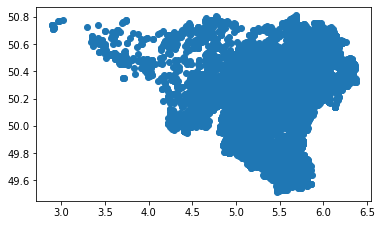

In [21]:
data.plot()

<h2> Adding N2000 cell ID attribute to observation data </h2>

In [22]:
data = data.sjoin(grille_N2000, how='inner', predicate = 'intersects')
data.reset_index(inplace=True, drop = True)
#del(data['TAX'])
del(data['index_right'])

In [23]:
data.head()
data['Code'].value_counts()

10kmE400N305    534
10kmE398N301    485
10kmE396N303    477
10kmE394N301    449
10kmE397N297    406
               ... 
10kmE396N296      1
10kmE388N304      1
10kmE384N309      1
10kmE391N308      1
10kmE390N308      1
Name: Code, Length: 203, dtype: int64

<h2> Adding Natura 2000 attribute to observation data </h2>

In [24]:
# Getting the index list of points in Natura 2000 zone
N2000_obs = data.sjoin(N2000_areas, how='inner', predicate = 'intersects')
N2000_obs = N2000_obs.index.to_list()

data['N2000_AREA']= [True if i.Index in N2000_obs else False for i in data.itertuples()]
data['N2000_AREA'].value_counts()

False    13071
True      4296
Name: N2000_AREA, dtype: int64

<h2> Adding New Variables </h2>

In [25]:
data['COUNT']=1
data['MONTH'] = data['DATE'].apply(lambda x: x.month)
data['CURRENT_REPORT'] = data['DATE'].apply(lambda x: 1 if x.year >=2010 else 0)

<h2> Counting distribution of clues </h2>

In [26]:
def create_clues_pieplot(data, species, savefig=False):
    
    # Getting data
    df= data[data['TAXON'] == species]
    df.reset_index(inplace=True, drop = True)
    df = df.groupby(['UNITE']).count()['COUNT']
    
    # Creating plot
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df.plot.pie(y='UNITE',
                autopct='%1.1f%%',
                radius=1,
                pctdistance = 1.2,
                ax=ax,
                ylabel=None,
                xlabel=None,
                labeldistance=None,
                cmap='Paired',
                #shadow = True,
                startangle=0,
                legend=True,
                textprops={'color':"black",
                          'fontsize':12},
                wedgeprops = {'linewidth': 2,
                              'edgecolor':'w'},
                frame=False,
               )
    ax.set_title(f"Nature des données {i}")
    
    if savefig:
        fig.savefig(f"output/clues_{i}.png")

<h2> Counting number of observations in Natura 2000 areas </h2>

In [27]:
def create_N2000_pieplot(data, species, savefig=False):
    
    # Getting data
    df= data[data['TAXON'] == species]
    df.reset_index(inplace=True, drop = True)
    df = df.groupby(['N2000_AREA']).count()['COUNT']
    
    # Creating plot
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    df.plot.pie(y='N2000_AREA',
                autopct='%1.1f%%',
                radius=1,
                pctdistance = 1.2,
                ax=ax,
                ylabel=None,
                xlabel=None,
                labeldistance=None,
                cmap='Paired',
                #shadow = True,
                startangle=0,
                legend=True,
                textprops={'color':"black",
                          'fontsize':12},
                wedgeprops = {'linewidth': 2,
                              'edgecolor':'w'},
                frame=False,
               )
    ax.set_title(f"Répartition dans les zones NATURA 2000 {i}")
    
    
    
    if savefig:
        fig.savefig(f"output/N2000_{i}.png")

In [28]:

def create_distribution_map(sp, savefig=False):
    
    mapping={'Meles meles':{'color_obs':'tomato',
                            'image':'Meles_meles.png',
                            'color_old':'orange',
                            'color_actual':'darkorange',
                           },
             'Martes martes':{'color_obs':'saddlebrown',
                              'image':'Martes_martes.png',
                              'color_old':'peru',
                              'color_actual':'sienna',
                             },
             'Procyon lotor':{'color_obs':'teal',
                              'image':'Procyon_lotor.png',
                              'color_old':'lightseagreen',
                              'color_actual':'lightseagreen',
                             },
             'Mustela putorius':{'color_obs':'darkred',
                              'image':'Mustela_putorius.png',
                              'color_old':'burlywood',
                              'color_actual':'rosybrown',
                             },
            }
    
    grid = grille_N2000
    df = data[data['TAXON'] == sp]
    df = df.reset_index(drop=True)
    
    # Counting cells
    actual_cells = df[df['CURRENT_REPORT'] == True]
    n_actual_cells = actual_cells["Code"].value_counts().to_dict()
    grid['N_OBS_CURRENT_REPORT'] = grid['Code'].apply(lambda x: n_actual_cells.get(x, 0))
    grid['CURRENT_PRESENCE'] = grid['N_OBS_CURRENT_REPORT'] > 0
    
    old_cells = df[df['CURRENT_REPORT'] == False]
    n_old_cells = old_cells["Code"].value_counts().to_dict()
    grid['N_OBS_PREV_REPORT'] = grid['Code'].apply(lambda x: n_old_cells.get(x, 0))
    grid['OLD_PRESENCE'] = grid['N_OBS_PREV_REPORT'] > 0
    
    actual_cells = grid[grid['CURRENT_PRESENCE'] == True]
    previous_cells = grid[grid['OLD_PRESENCE'] == True]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    
    default = {'color_obs':'teal',
               'image':None,
               'color_old':'lightseagreen',
               'color_actual':'lightseagreen',
              }
    dico = mapping.get(sp, default)

    color = dico.get('color_old')
    previous_cells.plot(color=color,
                        alpha = 0.3,
                        edgecolor='k',
                        ax=ax,
                        label = 'Présence <2018',
                       )
    
    color = dico.get('color_actual')
    a= actual_cells.plot(color=color,
                      alpha = 0.9,
                      edgecolor='k',
                      legend=True,
                      ax=ax,
                      label = 'Rapportage en cours',
                     )
    color = dico.get('color_obs')
    df.plot(y='LAT',
            x='LON',
            ax=ax,
            color=color,#'tomato',
            kind='scatter',
            
            alpha=0.6,
            label = 'Observations validées',
            #title=sp,
                  )
    
    ax.set_title(f"Distribution des observations en Wallonie pour {sp} (N={len(df)})")
    ax.set_ylabel('Latitude', fontweight ='bold')
    ax.set_xlabel('Longitude', fontweight ='bold')
    
    provinces.boundary.plot(alpha = 0.3,
                   edgecolor='k',
                   ax=ax)
    
    biogeo_limit.plot(ax=ax,
                     color = 'black',
                     label = "Limite biogéographique")
    
    ax.legend(loc='lower left')
    
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    
    path = dico.get('image', False)
    if path:
        array_img = plt.imread(f"data/images/{path}")
        image = OffsetImage(array_img, 
                            zoom=.35 #Size reduction
                           )


        ab = AnnotationBbox(image,
                            (0.1, 0.2),
                            xycoords='axes fraction',
                           frameon=False)
        ax.add_artist(ab)
    

    if savefig:
        fig.savefig(f"output/N2000_{sp}.png",
                   dpi=100)


In [29]:
def create_year_count(data, sp, savefig=False):
    df = data[data['TAXON'] == sp]
    
    df = df[df['SOURCE'] == 'Obs.be']
    
    n_obs=[]
    for y in set(df['YEAR']):
        subset = df[df['YEAR']==y]
        n_obs.append(len(set(subset['OBSERVATEUR'])))
    
    data = df.set_index('DATE', drop = True)
    data['COUNT'] = 1
    data = data.resample('Y').sum()
    
    dates = data.index.year
    values = data["COUNT"]

    #obs = len(set(df['OBSERVATEUR']))
    
    #df=df.groupby('YEAR')['NOMBRE'].count()
    fig, ax = plt.subplots()
    ax.bar(dates, values, color='lightseagreen')
    ax.plot(dates, n_obs, color='red')
    ax.set_title(f"Nombre d'observations par mois - {sp}")
    
    plt.show()
    plt.close()

/Users/quentin/opt/miniconda3/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/quentin/opt/miniconda3/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/quentin/opt/miniconda3/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/quentin/opt/miniconda3/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


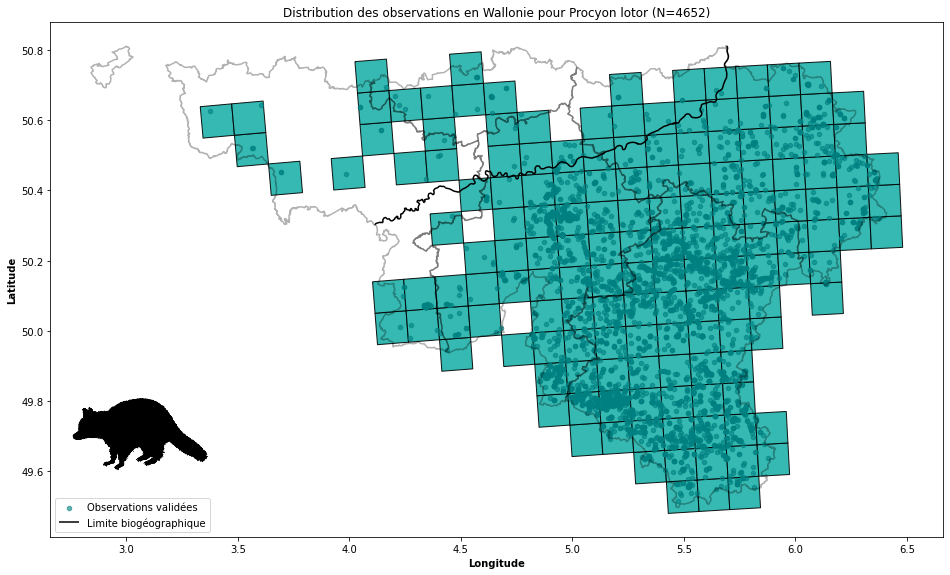

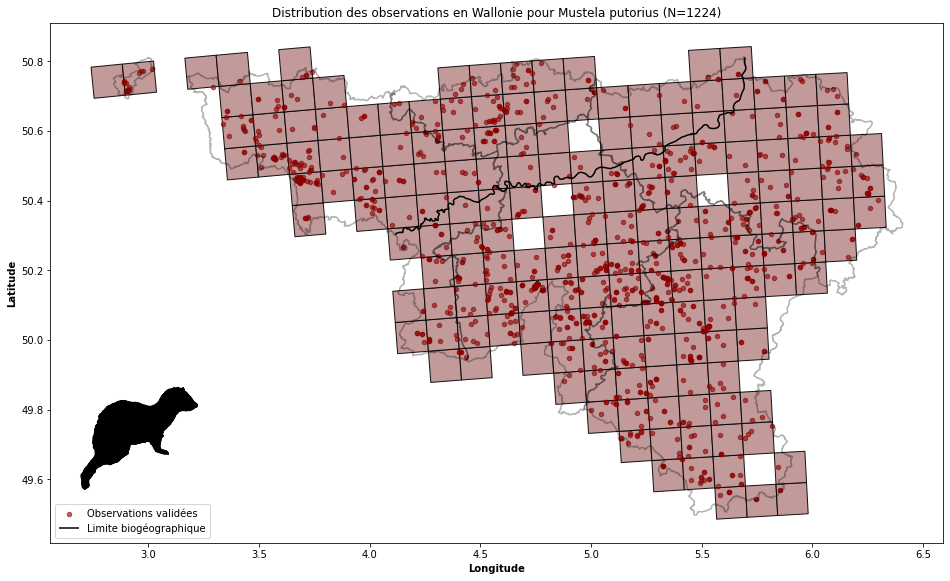

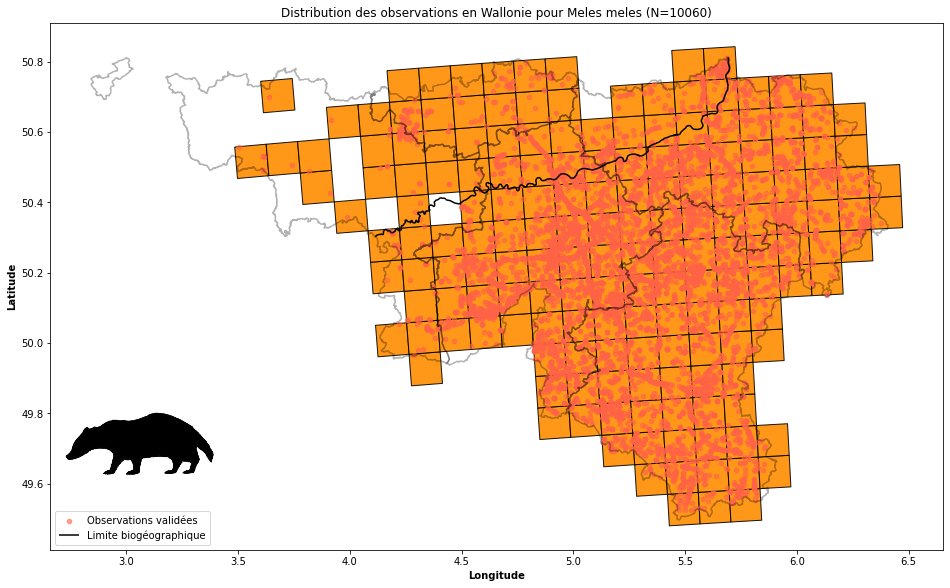

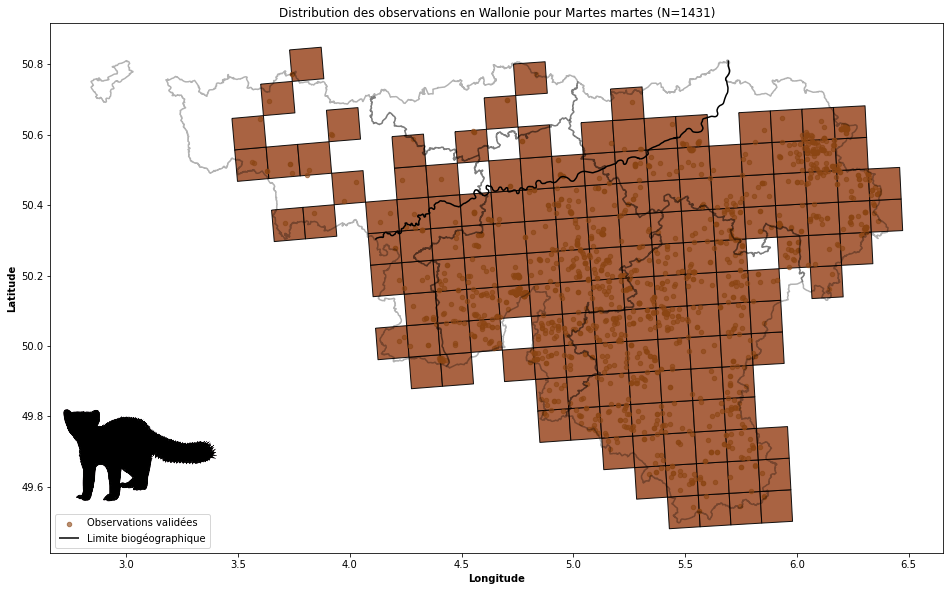

In [30]:
for sp in species_list:
    #create_clues_pieplot(data, sp, savefig=True)
    #create_N2000_pieplot(data, sp, savefig=True)
    #create_year_count(data, sp)
    create_distribution_map(sp, savefig=True)


<h1> Interactive Map </h1>

In [31]:
import ipywidgets as widgets
from matplotlib import pyplot as plt

<AxesSubplot:>

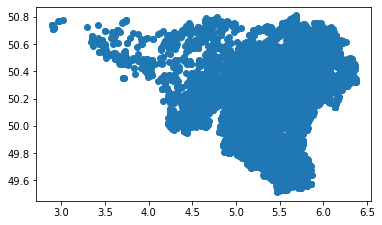

In [32]:
data.plot()

In [35]:
def distribution(sp, year, accumulation=False):
    
    # select data
    df = data[(data['YEAR']==year) & (data['TAXON']==sp)]
    
    if accumulation:
        df = data[(data['YEAR']<=year) & (data['TAXON']==sp)]

    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    
    if not df.empty:
        df.plot(ax=ax)
        
    provinces.boundary.plot(alpha = 0.3,
                   edgecolor='k',
                   ax=ax)
    
    ax.set_title(f"Distribution des observations validées en Wallonie pour {sp} (N={len(df)})")
    ax.set_ylabel('Latitude', fontweight ='bold')
    ax.set_xlabel('Longitude', fontweight ='bold')
    

    

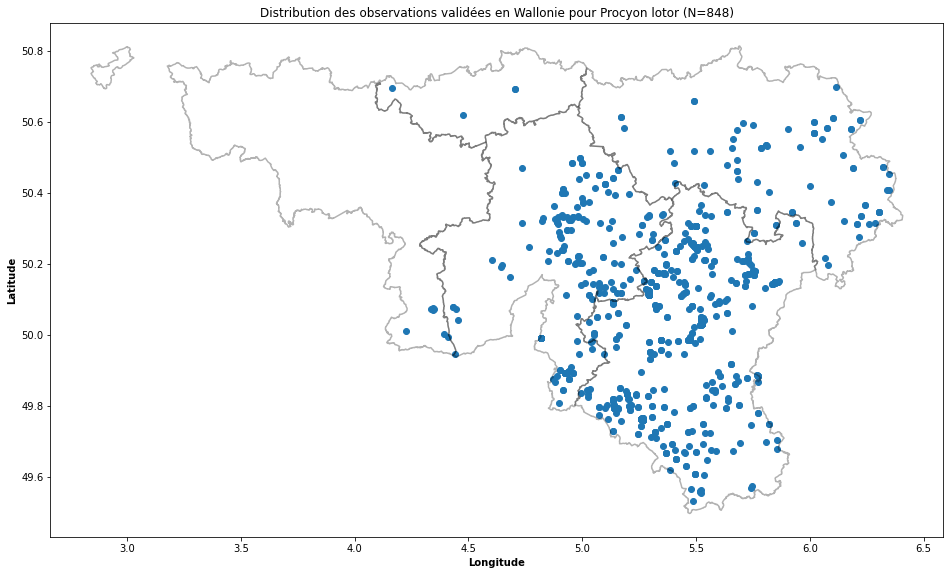

In [36]:
distribution('Procyon lotor', 2021)

In [37]:
h = widgets.interact(distribution, year=(2000, 2020, 1), sp=species_list, accumulation=True)

interactive(children=(Dropdown(description='sp', options=('Procyon lotor', 'Mustela putorius', 'Meles meles', …

In [38]:
import plotly.io as pio
import plotly.graph_objects as go

pio.write_html(h, file="Forecast_HTML.html", auto_open=True)

ValueError: 
The fig parameter must be a dict or Figure.
    Received value of type <class 'function'>: <function distribution at 0x1067b35e0>